
# Telecom Churn (Cease) Project — Exploratory Data Analysis

This notebook performs a **business-focused EDA** for the UK Telecoms cease/churn assessment.

## Business objective
Prioritise retention effort by identifying customers most likely to **place a cease** (leave) soon, so the retention team can focus calls on higher-risk customers.

## Data sources used
- `cease` 
- `customer_info` 
- `calls` 
- `usage` 


## 1) Setup and imports

In [1]:

# Core imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 180)

### Quick Preview of all dataset

In [2]:
#Create a connection to the duckdb database
catalog_db = duckdb.connect("UK_telecom.duckdb")


# Quick preview of calls file
calls_csv_preview = catalog_db.execute("""
    SELECT *
    FROM read_csv_auto('../data/calls.csv')
    LIMIT 100
""").df()

print("CSV preview:")
print(calls_csv_preview)

CSV preview:
                           unique_customer_identifier event_date call_type  talk_time_seconds  hold_time_seconds
0   aae0258b41e6e88365d7d5ce648ea69d837602b4bb419e... 2023-02-22   Loyalty              627.0              235.0
1   15f9f6fc1872bbf6963a84de253d600e5d18d75d7784ce... 2023-03-16      Tech              267.0              293.0
2   c18d59888cb050a5694d1e613a277d79b4a3083bd1b813... 2023-02-22   Loyalty              689.0                0.0
3   1316da4b4282f98b572666413a71592352cc869c976212... 2023-03-16      Tech             3233.0                0.0
4   6f33a33df6e18900a60d495eb19f2c7b238a13ec5cd894... 2023-03-16      Tech                2.0                0.0
..                                                ...        ...       ...                ...                ...
95  b17a215acd1cd25604e0b6732680eaf3fd15d68e9db661... 2023-03-16      Tech              424.0                0.0
96  0e5b159902fe768b4cc1b80e211522695e8e7ebffc2ad6... 2023-03-16      Tech         

In [3]:
#Create a connection to the duckdb database
catalog_db = duckdb.connect("UK_telecom.duckdb")


# Quick preview of cease file
cease_csv_preview = catalog_db.execute("""
    SELECT *
    FROM read_csv_auto('../data/cease.csv')
    LIMIT 100
""").df()

print("CSV preview:")
print(cease_csv_preview)

CSV preview:
                           unique_customer_identifier cease_placed_date cease_completed_date                     reason_description reason_description_insight
0   03b1c584533a86d067dd51bbca242db2b55b692f10d325...        2023-08-03           2023-09-04  Competitor Deals - No longer required            CompetitorDeals
1   97a7bdce317de91a32636e6675bbb2e5b25573308ef7bb...        2023-08-03           2023-09-04                                  Cease                VagueReason
2   c5049a1aedc36d7d7379c2c2144972b099521e6614cf8c...        2023-08-03           2023-09-05  Competitor Deals - No longer required            CompetitorDeals
3   cffa7eecb1708776f425a0f1e70598710b5e74a66d8fea...        2023-08-03           2023-08-21                              Not Known                VagueReason
4   f450c8a916d400b204b0228fa23bf613ceae5727e08a68...        2023-08-03           2023-09-04  Competitor Deals - No longer required            CompetitorDeals
..                               

In [4]:
# Quick preview of customer_info parquet file
customer_info_preview = catalog_db.execute("""
    SELECT *
    FROM read_parquet('../data/customer_info.parquet')
    LIMIT 100
""").df()

print("Parquet preview:")
customer_info_preview.tail(10)

Parquet preview:


,unique_customer_identifier,datevalue,contract_status,contract_dd_cancels,dd_cancel_60_day,ooc_days,technology,speed,line_speed,sales_channel,crm_package_name,tenure_days
90,7113b840dabb8224fde90ff25217acfbef4fb55a904ce1...,2024-06-01,01 Early Contract,0,0,-464,FTTC,65,58.364000,Migrated Customer,Fibre 65 (FTTC-OR),5608
91,3a04caa130b62e474c4bbcac5a3ab2dfc6002593263249...,2023-11-01,02 In Contract,0,0,-221,FTTC,65,75.956000,Online - Ambient,Fibre 65 (FTTC-OR),2469
92,fe7be4f4d5685b5085ddfa564b35e419d2dab768380460...,2023-12-01,03 Soon to be OOC,0,0,-63,FTTC,35,39.997000,Online - Affiliate,Fibre 35 (FTTC-OR),2353
93,bde98b50ca6b44cdbe4c6727a718646d2ad1c8dbc787b3...,2024-01-01,02 In Contract,0,0,-431,FTTC,65,49.525000,Migrated Customer,Fibre 65 (FTTC-OR),5908
94,64ae1867c8fafcad80af72855af3ccd61944cffd1ff810...,2023-01-01,01 Early Contract,0,0,-715,FTTC,35,29.209584,Migrated Customer,Fibre 35 (FTTC-OR),6815
95,7c3e411532d6ca0d03ff25440f56e4c72002abe6a91ba0...,2023-09-01,04 Coming OOC,0,0,-17,MPF,18,14.409180,Unknown,Fast Broadband,5324
96,066c39e667a512aefc28a2a1326eb4ada0ab5ceaa90c87...,2023-11-01,06 OOC,0,0,119,FTTC,65,45.783000,Unknown,Fibre 65 (FTTC-OR),5293
97,35583a0190aebcc9f485feb53dd670056b1cea6a7a086f...,2024-06-01,06 OOC,0,0,100,FTTC,65,66.635000,Migrated Customer,Fibre 65 (FTTC-OR),5324
98,414e79d2dd18d01b238ebba5c4539cd363bed9be2d2053...,2023-03-01,05 Newly OOC,0,0,43,FTTC,65,79.999000,Migrated Customer,Fibre 65 (FTTC-OR),5552
99,c820d47689b6792335bfb3dee1eec3007aa5af4915fe78...,2024-07-01,06 OOC,0,0,2759,MPF,18,39.806000,Migrated Customer,Plus TV Access Everything with Fibre,6229


In [5]:
# Quick preview of usage parquet file
usage_preview = catalog_db.execute("""
    SELECT *
    FROM read_parquet('../data/usage.parquet')
    LIMIT 100
""").df()

print("Parquet preview:")
usage_preview.head(10)

Parquet preview:


,unique_customer_identifier,calendar_date,usage_download_mbs,usage_upload_mbs
0,9a87ea1d3811ec1b9c78d9fd12365648ba2203508545c6...,2022-09-22,9860.716,1032.873
1,d03550f4797142c2fe145fcbeb7ec247b7771b5153605d...,2022-09-22,3200.633,151.137
2,ed854191c887a386f417e64bb0814ffa157d147891b070...,2022-09-22,3474.182,106.833
3,1ac8215f9e98d15b235e6baa5b4a45dafa930201348b23...,2022-09-22,16601.283,1510.906
4,17f6b51c5295d23443a9e0736dd2209b76aba82cbef303...,2022-09-22,4788.412,168.129
5,28305b0142631079c8b2fa51149867a143de44b9f303e9...,2022-09-22,13922.517,372.234
6,009496584d3f34d82d40a271a28196abe78f0a73a04050...,2022-09-22,10062.910,445.010
7,6e150f4b6a34ad5b8a47d179847edc343a8286418dd92b...,2022-09-22,182.517,11.934
8,0ea9eddd944adcda453338e543c36eb7a41ca203723d50...,2022-09-22,1624.102,81.300
9,3489760e7b7a97af3af2fceaa7431fc6cd17e5b7b8b8e3...,2022-09-22,2479.076,287.534


 #### Dataset paths

In [6]:
#initializing current working directory
cwd = Path.cwd()
repo_dir = cwd.parent if cwd.name.lower() in {"notebook", "notebooks"} else cwd


output_dir = Path.cwd().parent / "eda_outputs"   # if notebook is inside /notebooks
output_dir.mkdir(parents=True, exist_ok=True)

# Default project data paths (edit if your names differ)
data_dir = repo_dir / "data"
cease_path = data_dir / "cease.csv"
calls_path = data_dir / "calls.csv"
customer_path = data_dir / "customer_info.parquet"
usage_path = data_dir / "usage.parquet"

#### Load Datasets 
#### The datasets provided for this project vary in format and size. To minimize memory overhead during exploratory data analysis, DuckDB was used so queries could be executed directly against the source files without loading entire datasets into Python objects

#### Call & Cease dataset (csv formats)

In [8]:
#Load CSV robustly into pandas + register a DuckDB view."""
def load_table(path:Path, table_name:str, catalog_db:duckdb.DuckDBPyConnection):
    """Load CSV/Parquet robustly into pandas + register a DuckDB view."""
    suffix = path.suffix.lower()
    if suffix == ".csv":
        df = catalog_db.execute(f"""
            SELECT *
            FROM read_csv_auto('{path.as_posix()}')
        """).df()

    else:
        raise ValueError(f"Unsupported file type for {path}")
    
    
    #register dataset and view for SQL exploration
    catalog_db.register(f"{table_name}_df", df)
    catalog_db.execute(f"CREATE OR REPLACE VIEW {table_name} AS SELECT * FROM {table_name}_df")
    return df    


def parse_dates_if_present(df: pd.DataFrame):
    date_like =[c for c in df.columns if "date" in c.lower() or "time" in c.lower()]
    for c in date_like:
        df[c] = pd.to_datetime(df[c], errors='coerce')
    return df

cease = parse_dates_if_present(load_table(cease_path, "cease", catalog_db))
calls = parse_dates_if_present(load_table(calls_path, "calls", catalog_db))




### Data Quality Checks (EDA Foundation)
(a) Cease | Calls dataset


In [9]:
print("Shapes:")
print("cease   :", cease.shape)
print("calls   :", calls.shape)

print(f"***************************************************************")

print(f"info for cease datasets")
cease.info()

print(f"***************************************************************")
print(f"info for calls datasets")
calls.info()

Shapes:
cease   : (146363, 5)
calls   : (628437, 5)
***************************************************************
info for cease datasets
<class 'pandas.DataFrame'>
RangeIndex: 146363 entries, 0 to 146362
Data columns (total 5 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   unique_customer_identifier  146363 non-null  str           
 1   cease_placed_date           146363 non-null  datetime64[us]
 2   cease_completed_date        119146 non-null  datetime64[us]
 3   reason_description          146363 non-null  str           
 4   reason_description_insight  146363 non-null  str           
dtypes: datetime64[us](2), str(3)
memory usage: 19.2 MB
***************************************************************
info for calls datasets
<class 'pandas.DataFrame'>
RangeIndex: 628437 entries, 0 to 628436
Data columns (total 5 columns):
 #   Column                      Non-Null Count   Dtype        

In [10]:

# Duplicate checks (record-level and key-level)
checks = {
    'calls_row_duplicates': calls.duplicated().sum(),
    'cease_row_duplicates': cease.duplicated().sum(),
    'calls_dup_customer_date': calls.duplicated(['unique_customer_identifier','event_date']).sum(),
}
pd.DataFrame(list(checks.items()), columns=['check','value'])

,check,value
0,calls_row_duplicates,6486
1,cease_row_duplicates,350
2,calls_dup_customer_date,269110


### 

*****************************************************************
#### Observation

<b> Cease Dataset </b>

- 146,363 rows, 5 columns; suitable for event-level churn/cease analysis.

- Strong data quality: all key fields are complete except cease_completed_date (27,217 missing).

- Missing cease_completed_date may carry business meaning (e.g., pending/incomplete ceases) and should be investigated.

- cease_placed_date is the main field for defining the churn/cease target window.

- reason_description and reason_description_insight are useful for churn reason segmentation and explainability.

<b> Cease Dataset : Duplicates </b>
- cease_row_duplicates = 350

- There are 350 fully duplicated rows in the cease dataset.

- Same issue: exact duplicate records.

- Risk: can inflate cease counts and distort target creation if not removed.

<b> Calls Dataset </b>

- 628,437 rows, 5 columns; key dataset for customer interaction/behaviour features.

- High completeness across fields (no visible missing values).

- talk_time_seconds and hold_time_seconds appear to be stored as datetime, not numeric durations — this needs correction before feature engineering.

- Well suited for building rolling behavioural features (e.g., call volume, repeat calls, hold-time metrics, retention/loyalty contact patterns).

<b>Calls Dataset : Duplicates </b>
- calls_row_duplicates = 6,486

- There are 6,486 fully duplicated rows in the calls dataset.

- This means all columns in those rows are identical copies of another row.

- Risk: double-counting call events, inflated call volumes, biased features (e.g., call frequency, hold time totals).



<b> Modelling Readiness (Overall) </b>

- Both datasets are strong foundations for churn modelling with clear identifiers and high completeness.

- Cease data supports target creation and churn reason analysis.

- Calls data provides valuable behavioural signals but requires duration field type conversion.

- Together, they support a robust cease-risk prediction and retention prioritisation workflow.

- Exact row duplicates (calls_row_duplicates, cease_row_duplicates) should usually be removed.

- Customer-date duplicates should be investigated before removal, because they may represent valid multiple same-day interactions.

### 



***************************************************
(b) Customer info | usage dataset (Large Parquet files)

In [11]:


data_dir = Path("../data")
parquet_files = list(data_dir.glob("*.parquet"))

for file_path in parquet_files:
    file_str = file_path.as_posix()

    # Shape
    row_count = catalog_db.execute(f"""
        SELECT COUNT(*) AS n_rows
        FROM read_parquet('{file_str}')
    """).fetchone()[0]

    schema_df = catalog_db.execute(f"""
        DESCRIBE SELECT * FROM read_parquet('{file_str}')
    """).df()

    col_count = len(schema_df)

    # Build non-null / null report per column
    info_rows = []
    for col in schema_df["column_name"].tolist():
        non_null_count = catalog_db.execute(f'''
            SELECT COUNT("{col}") 
            FROM read_parquet('{file_str}')
        ''').fetchone()[0]

        null_count = row_count - non_null_count
        null_pct = (null_count / row_count * 100) if row_count else 0

        col_type = schema_df.loc[schema_df["column_name"] == col, "column_type"].iloc[0]

        info_rows.append({
            "column_name": col,
            "non_null_count": int(non_null_count),
            "null_count": int(null_count),
            "null_pct": round(null_pct, 2),
            "dtype": col_type
        })

    info_df = pd.DataFrame(info_rows)

    # File size (parquet file size on disk)
    file_size_mb = file_path.stat().st_size / (1024 ** 2)

    # Print summary (.info()-like)
    print("\n" + "=" * 80)
    print(f"File: {file_path.name}")
    print(f"Rows: {row_count:,} | Columns: {col_count}")
    print(f"File size (disk): {file_size_mb:.2f} MB")
    print("-" * 80)
    print(info_df.to_string(index=False))


File: customer_info.parquet
Rows: 3,545,538 | Columns: 12
File size (disk): 257.54 MB
--------------------------------------------------------------------------------
               column_name  non_null_count  null_count  null_pct   dtype
unique_customer_identifier         3545538           0      0.00 VARCHAR
                 datevalue         3545538           0      0.00    DATE
           contract_status         3545538           0      0.00 VARCHAR
       contract_dd_cancels         3545538           0      0.00  BIGINT
          dd_cancel_60_day         3545538           0      0.00 INTEGER
                  ooc_days         3526590       18948      0.53 INTEGER
                technology         3545538           0      0.00 VARCHAR
                     speed         3545538           0      0.00 INTEGER
                line_speed         3545538           0      0.00  DOUBLE
             sales_channel         3545538           0      0.00 VARCHAR
          crm_package_name   

### 

*****************************************************************
#### Observation

Key Observations
<b> customer_info.parquet </b>

- Large, high-quality snapshot dataset: 3,545,538 rows × 12 columns (257.54 MB), suitable as the main monthly snapshot table for churn modelling.

- Very strong completeness: 11/12 columns are fully populated.

- Minor missingness: ooc_days has 0.53% nulls (18,948 rows) — low impact, but should be reviewed and handled.

- Strong churn features present: datevalue (snapshot date), contract_status, contract_dd_cancels, dd_cancel_60_day, ooc_days, tenure_days, plus package/channel/service fields.

- Data types are mostly modelling-ready for feature engineering.

<b> usage.parquet </b>

- Very large behavioural dataset: 83,185,050 rows × 4 columns (~2.95 GB), ideal for usage trend and churn-signal engineering.

- Excellent completeness: all columns are 100% populated.

- calendar_date is correctly typed as DATE, enabling rolling-window features (e.g., 7/30/90-day usage).

- Key preprocessing issue: usage_download_mbs and usage_upload_mbs are stored as VARCHAR and must be converted to numeric before analysis/modeling.

- Best handled with DuckDB (or similar) for memory-efficient EDA and aggregations.

<b> Overall Data Readiness </b> 

- Data quality is strong overall and suitable for a robust churn/cease modelling workflow.

- Main preprocessing priorities:

- Handle missing values in ooc_days

- Convert usage fields from VARCHAR to numeric

<b> Modelling roles: </b> 

- customer_info = snapshot anchor dataset

- usage = behavioural feature source (trend/decline/volatility signals)

In [16]:


customer_path = data_dir / "customer_info.parquet"

# Register a view (no full pandas load)
catalog_db.execute(f"""
    CREATE OR REPLACE VIEW customer AS
    SELECT * FROM read_parquet('{customer_path.as_posix()}')
""")

# Count exact duplicate rows (all columns identical)
dup_summary = catalog_db.execute("""
    WITH row_counts AS (
        SELECT *, COUNT(*) AS row_cnt
        FROM customer
        GROUP BY ALL
    )
    SELECT
        COUNT(*) AS unique_row_groups,
        SUM(CASE WHEN row_cnt > 1 THEN 1 ELSE 0 END) AS duplicate_row_groups,
        SUM(CASE WHEN row_cnt > 1 THEN row_cnt - 1 ELSE 0 END) AS duplicate_extra_rows
    FROM row_counts
""").df()

print(dup_summary)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   unique_row_groups  duplicate_row_groups  duplicate_extra_rows
0            3532720               12818.0               12818.0


In [14]:
#Further duplicate check by customer id and datevalue 
# Check duplicates by business key: customer_id + datevalue
dup_customer_date = catalog_db.execute("""
    SELECT
       unique_customer_identifier,
        datevalue,
        COUNT(*) AS cnt
    FROM customer
    GROUP BY unique_customer_identifier, datevalue
    HAVING COUNT(*) > 1
    ORDER BY cnt DESC, unique_customer_identifier, datevalue
""").df()

print("Duplicate unique_customer_identifier + datevalue groups:")
print(dup_customer_date.head(20))
print(f"Total duplicate groups: {len(dup_customer_date)}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Duplicate unique_customer_identifier + datevalue groups:
                           unique_customer_identifier  datevalue  cnt
0   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2022-08-01    2
1   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2022-09-01    2
2   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2022-10-01    2
3   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2022-11-01    2
4   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2022-12-01    2
5   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-01-01    2
6   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-02-01    2
7   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-03-01    2
8   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-04-01    2
9   0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-05-01    2
10  0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-06-01    2
11  0120a0bd056bcd1356098b0d7cdd0bbde39615d9e36f1e... 2023-07-01    2
12  0120a0bd056bcd1356098b0d7cdd0

### 

*****************************************************************
#### Observation

- The duplication level appears small relative to the dataset size (good sign)

<b> But duplicates can still affect:</b>

- churn counts

- feature aggregations

- model training (double-counting some customers/snapshots)

## Individual data EDA & business relevenat patterns

<b> 1. Cease data </b>

,reason_description_insight,count
0,VagueReason,76055
1,CompetitorDeals,51878
2,Bereavement,8695
3,Other,4080
4,HomeMove,2969
5,TechnicalIssue,1586
6,BadDebtDisconnect,533
7,Mis-sold,229
8,CustomerServices,220
9,Installation&Provisioning,116


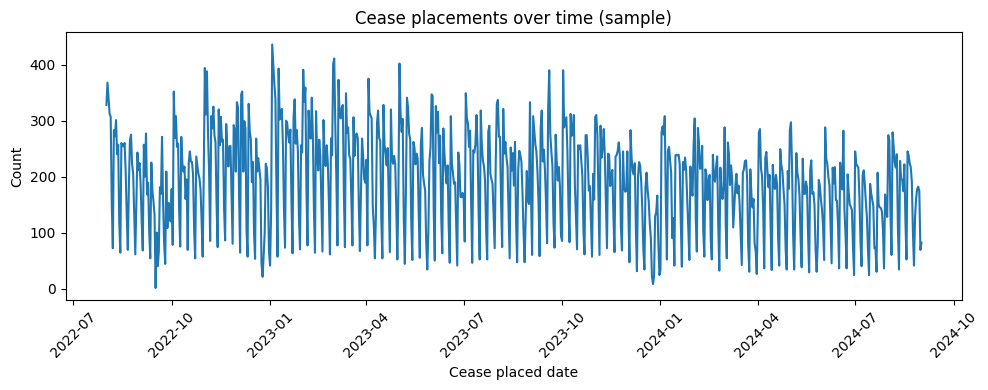

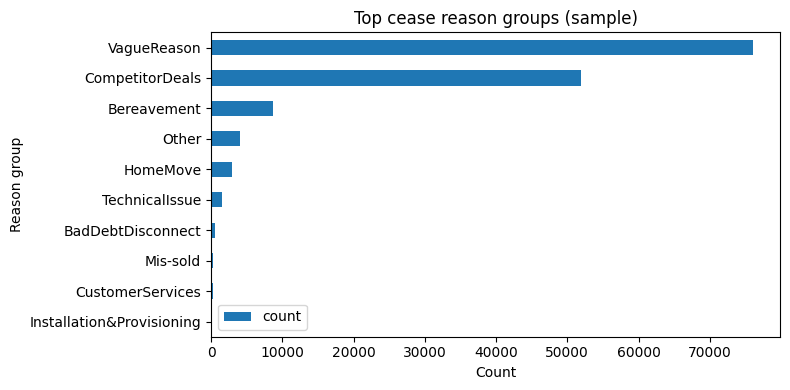

In [22]:
# Cease trends and reasons
cease_daily = cease.groupby('cease_placed_date', dropna=False).size().rename('cease_count').reset_index()
reason_counts = cease['reason_description_insight'].value_counts(dropna=False).rename_axis('reason_description_insight').reset_index(name='count')

display(reason_counts.head(10))

fig, ax = plt.subplots(figsize=(10,4))
cease_daily = cease_daily.sort_values('cease_placed_date')
ax.plot(cease_daily['cease_placed_date'], cease_daily['cease_count'])
ax.set_title('Cease placements over time (sample)')
ax.set_xlabel('Cease placed date')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'cease_trends.png', dpi=150)
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
reason_counts.head(10).sort_values('count').plot(kind='barh', x='reason_description_insight', y='count', ax=ax)
ax.set_title('Top cease reason groups (sample)')
ax.set_xlabel('Count')
ax.set_ylabel('Reason group')
plt.tight_layout()
plt.savefig(output_dir / 'top_cease_reason.png', dpi=150)
plt.show()


<b> Observation </b>

<b> Cease volumes are highly cyclical </b>

- The time-series line shows a strong repeating pattern (regular peaks and dips), which likely reflects weekly/operational seasonality.

- This means cease activity is not random — there is a clear temporal pattern that should be considered in modelling (e.g., day-of-week / week-based features).

<b> Overall cease levels appear to trend slightly downward over time </b>

- Earlier periods (around 2022–2023) show more frequent highs and higher peaks.

- By 2024, the values still fluctuate strongly, but the general level looks lower on average than earlier periods.

### ******************************************************

<b> 2. Customer info dataset (contract, tenure, DD cancels, package)</b>

In [18]:

# Connect
catalog_db = duckdb.connect("UK_telecom.duckdb")

# Register customer parquet as a view (adjust path if needed)
customer_parquet = Path("../data/customer_info.parquet")

catalog_db.execute(f"""
    CREATE OR REPLACE VIEW customer_info AS
    SELECT *
    FROM read_parquet('{customer_parquet.as_posix()}')
""")

# Create churn feature view (SQL equivalent of your pandas feature engineering)
catalog_db.execute("""
    CREATE OR REPLACE VIEW customer_features AS
    SELECT
        *,
        (speed - line_speed) AS speed_gap,
        CASE
            WHEN speed > 0 THEN line_speed * 1.0 / speed
            ELSE NULL
        END AS speed_ratio,
        CASE
            WHEN ooc_days > 0 THEN 1 ELSE 0
        END AS is_out_of_contract,
        CASE
            WHEN ooc_days BETWEEN -30 AND 0 THEN 1 ELSE 0
        END AS is_near_contract_end,
        CASE
            WHEN dd_cancel_60_day > 0 THEN 1 ELSE 0
        END AS dd_cancel_flag_60d
    FROM customer_info
""")

print("Created view: customer_features")

Created view: customer_features


<b>Feature view from customer_info (snapshot-level)</b>

In [19]:
cat_profile = catalog_db.execute("""
    SELECT 'contract_status' AS column_name,
           COUNT(*) AS total_rows,
           SUM(CASE WHEN contract_status IS NULL THEN 1 ELSE 0 END) AS null_rows,
           COUNT(DISTINCT contract_status) AS distinct_values
    FROM customer_features
    UNION ALL
    SELECT 'technology',
           COUNT(*),
           SUM(CASE WHEN technology IS NULL THEN 1 ELSE 0 END),
           COUNT(DISTINCT technology)
    FROM customer_features
    UNION ALL
    SELECT 'sales_channel',
           COUNT(*),
           SUM(CASE WHEN sales_channel IS NULL THEN 1 ELSE 0 END),
           COUNT(DISTINCT sales_channel)
    FROM customer_features
    UNION ALL
    SELECT 'crm_package_name',
           COUNT(*),
           SUM(CASE WHEN crm_package_name IS NULL THEN 1 ELSE 0 END),
           COUNT(DISTINCT crm_package_name)
    FROM customer_features
""").df()

cat_profile

,column_name,total_rows,null_rows,distinct_values
0,contract_status,3545538,0.0,6
1,technology,3545538,0.0,4
2,sales_channel,3545538,0.0,13
3,crm_package_name,3545538,0.0,64


<b> Top values per categorical column</b>

In [20]:
top_contract_status = catalog_db.execute("""
    SELECT contract_status, COUNT(*) AS cnt
    FROM customer_features
    GROUP BY contract_status
    ORDER BY cnt DESC
    LIMIT 10
""").df()

top_technology = catalog_db.execute("""
    SELECT technology, COUNT(*) AS cnt
    FROM customer_features
    GROUP BY technology
    ORDER BY cnt DESC
    LIMIT 10
""").df()

top_sales_channel = catalog_db.execute("""
    SELECT sales_channel, COUNT(*) AS cnt
    FROM customer_features
    GROUP BY sales_channel
    ORDER BY cnt DESC
    LIMIT 10
""").df()

top_crm_package = catalog_db.execute("""
    SELECT crm_package_name, COUNT(*) AS cnt
    FROM customer_features
    GROUP BY crm_package_name
    ORDER BY cnt DESC
    LIMIT 10
""").df()

print("Top contract_status")
display(top_contract_status)

print("Top technology")
display(top_technology)

print("Top sales_channel")
display(top_sales_channel)

print("Top crm_package_name")
display(top_crm_package)

Top contract_status


,contract_status,cnt
0,02 In Contract,1673081
1,06 OOC,980655
2,03 Soon to be OOC,297006
3,01 Early Contract,280128
4,05 Newly OOC,194105
5,04 Coming OOC,120563


Top technology


,technology,cnt
0,FTTC,3012289
1,MPF,346213
2,GFAST,178152
3,FTTP,8884


Top sales_channel


,sales_channel,cnt
0,Online - Affiliate,885088
1,Migrated Customer,590712
2,Inbound,465320
3,Unknown,433451
4,Partners,297457
5,Online - Search,289458
6,Retail,221620
7,Online - Ambient,182657
8,Webchat,79986
9,Field,39498


Top crm_package_name


,crm_package_name,cnt
0,Fibre 65 (FTTC-OR),1784809
1,Fibre 35 (FTTC-OR),911961
2,Faster Fibre,311508
3,Fast Broadband,251250
4,Fibre 150 (GFast-OR),170048
5,Broadband Only (SMPF),10590
6,BB (SMPF),10448
7,Fibre 150 VoIP (FTTP-CF),8883
8,Fibre 250 (GFast-OR),8104
9,SimplyBroadband,6765


<b>3. Usage data (Behavioural Patterns) </b>

,call_type,n_calls,avg_talk_s,avg_hold_s,avg_hold_ratio
0,Tech,171942,887.754621,192.088326,0.296852
1,CS&B,167117,665.655481,172.260638,0.348631
2,Loyalty,144269,653.617978,254.498222,0.562061
3,Customer Finance,71105,428.256269,118.686112,0.396131
4,FTTP,43926,672.355120,236.907230,0.497536
5,null,17948,72.919044,6.239915,0.112430
6,Other,5385,808.668338,79.771216,0.124971
7,Order Management,4422,383.581411,104.730439,0.431668
8,Complaints,1504,1108.925532,135.269282,0.121306
9,TTB - Sales,369,240.520325,47.926829,0.298950


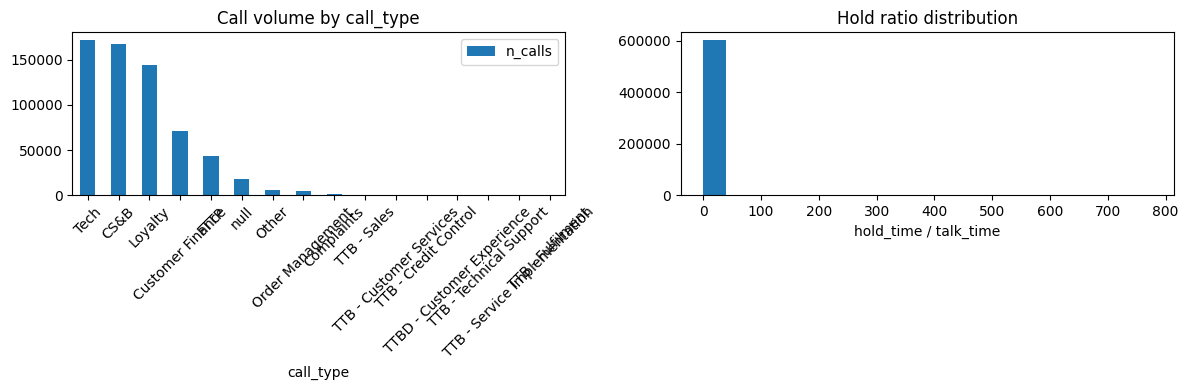

In [25]:


# 1) Force numeric conversion (invalid values become NaN)
calls['talk_time_seconds'] = pd.to_numeric(calls['talk_time_seconds'], errors='coerce')
calls['hold_time_seconds'] = pd.to_numeric(calls['hold_time_seconds'], errors='coerce')

# 2) Create hold_ratio safely (avoid divide-by-zero)
calls['hold_ratio'] = np.where(
    calls['talk_time_seconds'].fillna(0) > 0,
    calls['hold_time_seconds'] / calls['talk_time_seconds'],
    np.nan
)

# 3) Aggregate call summary
call_summary = (
    calls.groupby('call_type', dropna=False)
    .agg(
        n_calls=('unique_customer_identifier', 'size'),
        avg_talk_s=('talk_time_seconds', 'mean'),
        avg_hold_s=('hold_time_seconds', 'mean'),
        avg_hold_ratio=('hold_ratio', 'mean')
    )
    .sort_values('n_calls', ascending=False)
    .reset_index()
)

display(call_summary)

# 4) Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

call_summary.plot(
    kind='bar',
    x='call_type',
    y='n_calls',
    ax=axes[0],
    title='Call volume by call_type'
)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('call_type')

axes[1].hist(calls['hold_ratio'].dropna(), bins=20)
axes[1].set_title('Hold ratio distribution')
axes[1].set_xlabel('hold_time / talk_time')

plt.tight_layout()
plt.savefig(output_dir / 'calls_eda.png', dpi=150)
plt.show()

<b> Observation </b>


<b> Call volumes are concentrated in a few call types </b> 

- Tech, CS&B, and Loyalty are the dominant call types by a wide margin.

- This suggests most customer contact activity is concentrated in support/service and retention-related interactions.

<b>  A steep drop-off after the top categories </b>

- After the top 3–4 call types, volumes fall sharply.

- Several categories have very low volumes, which may be:

        - niche operational queues, or

        - inconsistent labels / fragmented call type naming.

<b> null appears as a call_type category </b>

- The presence of a visible null category means some records are missing call type classification.

- This is a data quality issue and should be addressed, especially if call_type is used as a churn feature

In [10]:
num_summary = catalog_db.execute("""
    SELECT * FROM (
        SELECT
            'contract_dd_cancels' AS column_name,
            COUNT(contract_dd_cancels) AS non_null_count,
            SUM(CASE WHEN contract_dd_cancels IS NULL THEN 1 ELSE 0 END) AS null_count,
            AVG(contract_dd_cancels) AS mean,
            STDDEV_SAMP(contract_dd_cancels) AS std,
            MIN(contract_dd_cancels) AS min,
            QUANTILE_CONT(contract_dd_cancels, 0.25) AS p25,
            QUANTILE_CONT(contract_dd_cancels, 0.50) AS median,
            QUANTILE_CONT(contract_dd_cancels, 0.75) AS p75,
            MAX(contract_dd_cancels) AS max
        FROM customer_features

        UNION ALL

        SELECT
            'dd_cancel_60_day',
            COUNT(dd_cancel_60_day),
            SUM(CASE WHEN dd_cancel_60_day IS NULL THEN 1 ELSE 0 END),
            AVG(dd_cancel_60_day),
            STDDEV_SAMP(dd_cancel_60_day),
            MIN(dd_cancel_60_day),
            QUANTILE_CONT(dd_cancel_60_day, 0.25),
            QUANTILE_CONT(dd_cancel_60_day, 0.50),
            QUANTILE_CONT(dd_cancel_60_day, 0.75),
            MAX(dd_cancel_60_day)
        FROM customer_features

        UNION ALL

        SELECT
            'ooc_days',
            COUNT(ooc_days),
            SUM(CASE WHEN ooc_days IS NULL THEN 1 ELSE 0 END),
            AVG(ooc_days),
            STDDEV_SAMP(ooc_days),
            MIN(ooc_days),
            QUANTILE_CONT(ooc_days, 0.25),
            QUANTILE_CONT(ooc_days, 0.50),
            QUANTILE_CONT(ooc_days, 0.75),
            MAX(ooc_days)
        FROM customer_features

        UNION ALL

        SELECT
            'speed',
            COUNT(speed),
            SUM(CASE WHEN speed IS NULL THEN 1 ELSE 0 END),
            AVG(speed),
            STDDEV_SAMP(speed),
            MIN(speed),
            QUANTILE_CONT(speed, 0.25),
            QUANTILE_CONT(speed, 0.50),
            QUANTILE_CONT(speed, 0.75),
            MAX(speed)
        FROM customer_features

        UNION ALL

        SELECT
            'line_speed',
            COUNT(line_speed),
            SUM(CASE WHEN line_speed IS NULL THEN 1 ELSE 0 END),
            AVG(line_speed),
            STDDEV_SAMP(line_speed),
            MIN(line_speed),
            QUANTILE_CONT(line_speed, 0.25),
            QUANTILE_CONT(line_speed, 0.50),
            QUANTILE_CONT(line_speed, 0.75),
            MAX(line_speed)
        FROM customer_features

        UNION ALL

        SELECT
            'speed_gap',
            COUNT(speed_gap),
            SUM(CASE WHEN speed_gap IS NULL THEN 1 ELSE 0 END),
            AVG(speed_gap),
            STDDEV_SAMP(speed_gap),
            MIN(speed_gap),
            QUANTILE_CONT(speed_gap, 0.25),
            QUANTILE_CONT(speed_gap, 0.50),
            QUANTILE_CONT(speed_gap, 0.75),
            MAX(speed_gap)
        FROM customer_features

        UNION ALL

        SELECT
            'speed_ratio',
            COUNT(speed_ratio),
            SUM(CASE WHEN speed_ratio IS NULL THEN 1 ELSE 0 END),
            AVG(speed_ratio),
            STDDEV_SAMP(speed_ratio),
            MIN(speed_ratio),
            QUANTILE_CONT(speed_ratio, 0.25),
            QUANTILE_CONT(speed_ratio, 0.50),
            QUANTILE_CONT(speed_ratio, 0.75),
            MAX(speed_ratio)
        FROM customer_features

        UNION ALL

        SELECT
            'tenure_days',
            COUNT(tenure_days),
            SUM(CASE WHEN tenure_days IS NULL THEN 1 ELSE 0 END),
            AVG(tenure_days),
            STDDEV_SAMP(tenure_days),
            MIN(tenure_days),
            QUANTILE_CONT(tenure_days, 0.25),
            QUANTILE_CONT(tenure_days, 0.50),
            QUANTILE_CONT(tenure_days, 0.75),
            MAX(tenure_days)
        FROM customer_features
    )
    ORDER BY column_name
""").df()

num_summary

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,column_name,non_null_count,null_count,mean,std,min,p25,median,p75,max
0,contract_dd_cancels,3545538,0.0,0.037924,0.191012,0.000,0.000000,0.000000,0.000000,1.000000
1,dd_cancel_60_day,3545538,0.0,0.020146,0.140501,0.000,0.000000,0.000000,0.000000,1.000000
2,line_speed,3545538,0.0,49.533483,36.183102,0.000,29.940129,40.000000,71.695000,3520.168000
3,ooc_days,3526590,18948.0,91.410221,870.475084,-729.000,-338.000000,-129.000000,142.000000,7822.000000
4,speed,3545538,0.0,56.026869,42.188761,18.000,35.000000,65.000000,65.000000,1000.000000
5,speed_gap,3545538,0.0,6.493386,38.978765,-3455.168,-6.802000,0.001000,15.838802,1000.000000
6,speed_ratio,3545538,0.0,0.867083,0.417678,0.000,0.676229,0.999975,1.142829,54.156431
7,tenure_days,3545538,0.0,2340.789893,1878.749864,1.000,770.000000,1675.000000,3887.000000,10062.000000


##### Business Related EDA

1.	Churn rate by contract status
2.	Churn rate by ooc_days buckets
3.	Churn rate by direct debit cancels
4.	Churn rate by call volume / loyalty calls
5.	Churn rate by usage decline
6.	Churn rate by technology / package / sales channel


In [11]:

# ============================================================
# 1) Setup paths and DuckDB connection
# ============================================================
catalog_db = duckdb.connect("UK_telecom.duckdb")

# Adjust these paths if needed
data_dir = Path("../data")

cease_path = data_dir / "cease.csv"
calls_path = data_dir / "calls.csv"
customer_path = data_dir / "customer_info.parquet"
usage_path = data_dir / "usage.parquet"

# If local project files are not present, fallback to uploaded samples (optional)
if not cease_path.exists():
    cease_path = Path("/mnt/data/duck_cease_100_from_csv.csv")
if not calls_path.exists():
    calls_path = Path("/mnt/data/duck_calls_100_from_csv.csv")
if not customer_path.exists():
    customer_path = Path("/mnt/data/duck_customer_info_100.parquet")
if not usage_path.exists():
    usage_path = Path("/mnt/data/duck_usage_100.parquet")

print("Using:")
print(" cease   ->", cease_path)
print(" calls   ->", calls_path)
print(" customer->", customer_path)
print(" usage   ->", usage_path)

# ============================================================
# 2) Register source views (DuckDB reads directly from files)
# ============================================================
catalog_db.execute(f"""
    CREATE OR REPLACE VIEW cease_raw AS
    SELECT * FROM read_csv_auto('{cease_path.as_posix()}')
""")

catalog_db.execute(f"""
    CREATE OR REPLACE VIEW calls_raw AS
    SELECT * FROM read_csv_auto('{calls_path.as_posix()}')
""")

catalog_db.execute(f"""
    CREATE OR REPLACE VIEW customer_raw AS
    SELECT * FROM read_parquet('{customer_path.as_posix()}')
""")

catalog_db.execute(f"""
    CREATE OR REPLACE VIEW usage_raw AS
    SELECT * FROM read_parquet('{usage_path.as_posix()}')
""")

# ============================================================
# 3) Standardize types / create clean base views
# ============================================================
# customer snapshot table
catalog_db.execute("""
    CREATE OR REPLACE VIEW customer_info AS
    SELECT
        unique_customer_identifier,
        CAST(datevalue AS DATE) AS snapshot_date,
        contract_status,
        contract_dd_cancels,
        dd_cancel_60_day,
        ooc_days,
        Technology AS technology,
        speed,
        line_speed,
        sales_channel,
        crm_package_name,
        tenure_days
    FROM customer_raw
""")

# cease placements
catalog_db.execute("""
    CREATE OR REPLACE VIEW cease AS
    SELECT
        unique_customer_identifier,
        CAST(cease_placed_date AS DATE) AS cease_placed_date,
        CAST(cease_completed_date AS DATE) AS cease_completed_date,
        reason_description,
        reason_description_insight
    FROM cease_raw
""")

# calls
catalog_db.execute("""
    CREATE OR REPLACE VIEW calls AS
    SELECT
        unique_customer_identifier,
        CAST(event_date AS DATE) AS event_date,
        call_type,
        TRY_CAST(talk_time_seconds AS DOUBLE) AS talk_time_seconds,
        TRY_CAST(hold_time_seconds AS DOUBLE) AS hold_time_seconds
    FROM calls_raw
""")

# usage
catalog_db.execute("""
    CREATE OR REPLACE VIEW usage_data AS
    SELECT
        unique_customer_identifier,
        CAST(calendar_date AS DATE) AS calendar_date,
        TRY_CAST(usage_download_mbs AS DOUBLE) AS usage_download_mbs,
        TRY_CAST(usage_upload_mbs AS DOUBLE) AS usage_upload_mbs
    FROM usage_raw
""")

# ============================================================
# 4) Build leakage-safe target: cease in next 30 days
# ============================================================
catalog_db.execute("""
    CREATE OR REPLACE VIEW customer_target_30d AS
    SELECT
        c.*,
        CASE
            WHEN EXISTS (
                SELECT 1
                FROM cease z
                WHERE z.unique_customer_identifier = c.unique_customer_identifier
                  AND z.cease_placed_date > c.snapshot_date
                  AND z.cease_placed_date <= c.snapshot_date + INTERVAL 30 DAY
            )
            THEN 1 ELSE 0
        END AS target_cease_30d
    FROM customer_info c
""")

# ============================================================
# 5) Feature engineering for business cuts
# ============================================================
# --- customer-level derived features ---
catalog_db.execute("""
    CREATE OR REPLACE VIEW customer_features AS
    SELECT
        *,
        CASE
            WHEN ooc_days < -90 THEN 'In contract (>90d left)'
            WHEN ooc_days BETWEEN -90 AND -31 THEN 'In contract (31-90d left)'
            WHEN ooc_days BETWEEN -30 AND 0 THEN 'Near contract end (<=30d)'
            WHEN ooc_days BETWEEN 1 AND 30 THEN 'Out of contract (1-30d)'
            WHEN ooc_days BETWEEN 31 AND 90 THEN 'Out of contract (31-90d)'
            WHEN ooc_days > 90 THEN 'Out of contract (90d+)'
            ELSE 'Unknown'
        END AS ooc_days_bucket,
        CASE WHEN dd_cancel_60_day > 0 THEN 1 ELSE 0 END AS dd_cancel_flag_60d
    FROM customer_target_30d
""")

# --- calls aggregated in lookback windows before snapshot ---
# We create both total call volume and loyalty calls (30d)
catalog_db.execute("""
    CREATE OR REPLACE VIEW calls_30d_features AS
    SELECT
        c.unique_customer_identifier,
        c.snapshot_date,
        COUNT(*) AS calls_30d,
        SUM(CASE WHEN lower(coalesce(cl.call_type, '')) LIKE '%loyalty%' THEN 1 ELSE 0 END) AS loyalty_calls_30d
    FROM customer_features c
    LEFT JOIN calls cl
      ON cl.unique_customer_identifier = c.unique_customer_identifier
     AND cl.event_date > c.snapshot_date - INTERVAL 30 DAY
     AND cl.event_date <= c.snapshot_date
    GROUP BY c.unique_customer_identifier, c.snapshot_date
""")

# --- usage decline features ---
# Compare most recent 30d usage vs prior 30d usage
catalog_db.execute("""
    CREATE OR REPLACE VIEW usage_decline_features AS
    SELECT
        c.unique_customer_identifier,
        c.snapshot_date,
        SUM(CASE
              WHEN u.calendar_date > c.snapshot_date - INTERVAL 30 DAY
               AND u.calendar_date <= c.snapshot_date
              THEN coalesce(u.usage_download_mbs,0) + coalesce(u.usage_upload_mbs,0)
              ELSE 0
            END) AS usage_30d,
        SUM(CASE
              WHEN u.calendar_date > c.snapshot_date - INTERVAL 60 DAY
               AND u.calendar_date <= c.snapshot_date - INTERVAL 30 DAY
              THEN coalesce(u.usage_download_mbs,0) + coalesce(u.usage_upload_mbs,0)
              ELSE 0
            END) AS usage_prev_30d
    FROM customer_features c
    LEFT JOIN usage_data u
      ON u.unique_customer_identifier = c.unique_customer_identifier
     AND u.calendar_date > c.snapshot_date - INTERVAL 60 DAY
     AND u.calendar_date <= c.snapshot_date
    GROUP BY c.unique_customer_identifier, c.snapshot_date
""")

catalog_db.execute("""
    CREATE OR REPLACE VIEW usage_decline_bucketed AS
    SELECT
        unique_customer_identifier,
        snapshot_date,
        usage_30d,
        usage_prev_30d,
        CASE
            WHEN usage_prev_30d IS NULL OR usage_prev_30d = 0 THEN 'No prior usage baseline'
            WHEN usage_30d <= 0.5 * usage_prev_30d THEN 'Decline >50%'
            WHEN usage_30d < usage_prev_30d THEN 'Decline 0-50%'
            WHEN usage_30d = usage_prev_30d THEN 'Flat'
            WHEN usage_30d > usage_prev_30d THEN 'Increase'
            ELSE 'Unknown'
        END AS usage_decline_bucket
    FROM usage_decline_features
""")

# --- final EDA base table ---
catalog_db.execute("""
    CREATE OR REPLACE VIEW churn_eda_base AS
    SELECT
        c.unique_customer_identifier,
        c.snapshot_date,
        c.target_cease_30d,
        c.contract_status,
        c.ooc_days,
        c.ooc_days_bucket,
        c.contract_dd_cancels,
        c.dd_cancel_60_day,
        c.dd_cancel_flag_60d,
        c.technology,
        c.crm_package_name,
        c.sales_channel,
        coalesce(cf.calls_30d, 0) AS calls_30d,
        coalesce(cf.loyalty_calls_30d, 0) AS loyalty_calls_30d,
        coalesce(uf.usage_30d, 0) AS usage_30d,
        coalesce(uf.usage_prev_30d, 0) AS usage_prev_30d,
        uf.usage_decline_bucket
    FROM customer_features c
    LEFT JOIN calls_30d_features cf
      ON c.unique_customer_identifier = cf.unique_customer_identifier
     AND c.snapshot_date = cf.snapshot_date
    LEFT JOIN usage_decline_bucketed uf
      ON c.unique_customer_identifier = uf.unique_customer_identifier
     AND c.snapshot_date = uf.snapshot_date
""")

# ============================================================
# 6) Business EDA churn-rate tables
#    (churn rate = AVG(target_cease_30d))
# ============================================================

def run_query(title, sql):
    print(f"\n--- {title} ---")
    df = catalog_db.execute(sql).df()
    print(df.head(20))
    return df

# 1) Churn rate by contract status
q1 = """
SELECT
    contract_status,
    COUNT(*) AS n_snapshots,
    SUM(target_cease_30d) AS n_churn_30d,
    ROUND(100.0 * AVG(target_cease_30d), 2) AS churn_rate_30d_pct
FROM churn_eda_base
GROUP BY contract_status
ORDER BY churn_rate_30d_pct DESC, n_snapshots DESC
"""
df_churn_contract_status = run_query("1) Churn rate by contract status", q1)

# 2) Churn rate by ooc_days buckets
q2 = """
SELECT
    ooc_days_bucket,
    COUNT(*) AS n_snapshots,
    SUM(target_cease_30d) AS n_churn_30d,
    ROUND(100.0 * AVG(target_cease_30d), 2) AS churn_rate_30d_pct
FROM churn_eda_base
GROUP BY ooc_days_bucket
ORDER BY churn_rate_30d_pct DESC, n_snapshots DESC
"""
df_churn_ooc = run_query("2) Churn rate by ooc_days buckets", q2)

# 3) Churn rate by direct debit cancels (2 views)
q3a = """
SELECT
    dd_cancel_flag_60d,
    COUNT(*) AS n_snapshots,
    SUM(target_cease_30d) AS n_churn_30d,
    ROUND(100.0 * AVG(target_cease_30d), 2) AS churn_rate_30d_pct
FROM churn_eda_base
GROUP BY dd_cancel_flag_60d
ORDER BY dd_cancel_flag_60d DESC
"""
df_churn_dd_flag = run_query("3a) Churn rate by DD cancel flag (last 60d)", q3a)

q3b = """
SELECT
    CASE
      WHEN dd_cancel_60_day IS NULL THEN 'Unknown'
      WHEN dd_cancel_60_day = 0 THEN '0'
      WHEN dd_cancel_60_day = 1 THEN '1'
      WHEN dd_cancel_60_day = 2 THEN '2'
      ELSE '3+'
    END AS dd_cancel_60d_bucket,
    COUNT(*) AS n_snapshots,
    SUM(target_cease_30d) AS n_churn_30d,
    ROUND(100.0 * AVG(target_cease_30d), 2) AS churn_rate_30d_pct
FROM churn_eda_base
GROUP BY 1
ORDER BY churn_rate_30d_pct DESC, n_snapshots DESC
"""
df_churn_dd_bucket = run_query("3b) Churn rate by DD cancel count bucket", q3b)

# 4) Churn rate by call volume / loyalty calls
# Call volume buckets
q4a = """
SELECT
    CASE
      WHEN calls_30d = 0 THEN '0 calls'
      WHEN calls_30d = 1 THEN '1 call'
      WHEN calls_30d BETWEEN 2 AND 3 THEN '2-3 calls'
      WHEN calls_30d BETWEEN 4 AND 6 THEN '4-6 calls'
      ELSE '7+ calls'
    END AS call_volume_bucket_30d,
    COUNT(*) AS n_snapshots,
    SUM(target_cease_30d) AS n_churn_30d,
    ROUND(100.0 * AVG(target_cease_30d), 2) AS churn_rate_30d_pct
FROM churn_eda_base
GROUP BY 1
ORDER BY churn_rate_30d_pct DESC, n_snapshots DESC
"""
df_churn_calls = run_query("4a) Churn rate by call volume (30d)", q4a)

# Loyalty calls buckets
q4b = """
SELECT
    CASE
      WHEN loyalty_calls_30d = 0 THEN '0 loyalty calls'
      WHEN loyalty_calls_30d = 1 THEN '1 loyalty call'
      WHEN loyalty_calls_30d BETWEEN 2 AND 3 THEN '2-3 loyalty calls'
      ELSE '4+ loyalty calls'
    END AS loyalty_call_bucket_30d,
    COUNT(*) AS n_snapshots,
    SUM(target_cease_30d) AS n_churn_30d,
    ROUND(100.0 * AVG(target_cease_30d), 2) AS churn_rate_30d_pct
FROM churn_eda_base
GROUP BY 1
ORDER BY churn_rate_30d_pct DESC, n_snapshots DESC
"""
df_churn_loyalty_calls = run_query("4b) Churn rate by loyalty calls (30d)", q4b)

# 5) Churn rate by usage decline
q5 = """
SELECT
    usage_decline_bucket,
    COUNT(*) AS n_snapshots,
    SUM(target_cease_30d) AS n_churn_30d,
    ROUND(100.0 * AVG(target_cease_30d), 2) AS churn_rate_30d_pct
FROM churn_eda_base
GROUP BY usage_decline_bucket
ORDER BY churn_rate_30d_pct DESC, n_snapshots DESC
"""
df_churn_usage_decline = run_query("5) Churn rate by usage decline", q5)

# 6) Churn rate by technology / package / sales channel
q6a = """
SELECT
    technology,
    COUNT(*) AS n_snapshots,
    SUM(target_cease_30d) AS n_churn_30d,
    ROUND(100.0 * AVG(target_cease_30d), 2) AS churn_rate_30d_pct
FROM churn_eda_base
GROUP BY technology
HAVING COUNT(*) >= 20
ORDER BY churn_rate_30d_pct DESC, n_snapshots DESC
"""
df_churn_tech = run_query("6a) Churn rate by technology", q6a)

q6b = """
SELECT
    crm_package_name,
    COUNT(*) AS n_snapshots,
    SUM(target_cease_30d) AS n_churn_30d,
    ROUND(100.0 * AVG(target_cease_30d), 2) AS churn_rate_30d_pct
FROM churn_eda_base
GROUP BY crm_package_name
HAVING COUNT(*) >= 20
ORDER BY churn_rate_30d_pct DESC, n_snapshots DESC
LIMIT 30
"""
df_churn_package = run_query("6b) Churn rate by package (top 30 shown)", q6b)

q6c = """
SELECT
    sales_channel,
    COUNT(*) AS n_snapshots,
    SUM(target_cease_30d) AS n_churn_30d,
    ROUND(100.0 * AVG(target_cease_30d), 2) AS churn_rate_30d_pct
FROM churn_eda_base
GROUP BY sales_channel
HAVING COUNT(*) >= 20
ORDER BY churn_rate_30d_pct DESC, n_snapshots DESC
"""
df_churn_sales_channel = run_query("6c) Churn rate by sales channel", q6c)

# ============================================================
# 7) (Optional) Export outputs for reporting / visuals
# ============================================================
output_dir = Path("eda_outputs")
output_dir.mkdir(parents=True, exist_ok=True)

df_churn_contract_status.to_csv(output_dir / "churn_rate_by_contract_status.csv", index=False)
df_churn_ooc.to_csv(output_dir / "churn_rate_by_ooc_bucket.csv", index=False)
df_churn_dd_flag.to_csv(output_dir / "churn_rate_by_dd_flag.csv", index=False)
df_churn_dd_bucket.to_csv(output_dir / "churn_rate_by_dd_cancel_bucket.csv", index=False)
df_churn_calls.to_csv(output_dir / "churn_rate_by_call_volume_30d.csv", index=False)
df_churn_loyalty_calls.to_csv(output_dir / "churn_rate_by_loyalty_calls_30d.csv", index=False)
df_churn_usage_decline.to_csv(output_dir / "churn_rate_by_usage_decline.csv", index=False)
df_churn_tech.to_csv(output_dir / "churn_rate_by_technology.csv", index=False)
df_churn_package.to_csv(output_dir / "churn_rate_by_package.csv", index=False)
df_churn_sales_channel.to_csv(output_dir / "churn_rate_by_sales_channel.csv", index=False)

print("\nSaved outputs to:", output_dir.resolve())

Using:
 cease   -> ..\data\cease.csv
 calls   -> ..\data\calls.csv
 customer-> ..\data\customer_info.parquet
 usage   -> ..\data\usage.parquet

--- 1) Churn rate by contract status ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

     contract_status  n_snapshots  n_churn_30d  churn_rate_30d_pct
0      04 Coming OOC       120563      27208.0               22.57
1       05 Newly OOC       194105      23221.0               11.96
2  03 Soon to be OOC       297006      24122.0                8.12
3             06 OOC       980655      38317.0                3.91
4  01 Early Contract       280128       6094.0                2.18
5     02 In Contract      1673081      19686.0                1.18

--- 2) Churn rate by ooc_days buckets ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

             ooc_days_bucket  n_snapshots  n_churn_30d  churn_rate_30d_pct
0  Near contract end (<=30d)       123795      27825.0               22.48
1    Out of contract (1-30d)        78299      12607.0               16.10
2   Out of contract (31-90d)       112574       9997.0                8.88
3  In contract (31-90d left)       297006      24122.0                8.12
4     Out of contract (90d+)       961707      37930.0                3.94
5                    Unknown        18948        387.0                2.04
6    In contract (>90d left)      1953209      25780.0                1.32

--- 3a) Churn rate by DD cancel flag (last 60d) ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   dd_cancel_flag_60d  n_snapshots  n_churn_30d  churn_rate_30d_pct
0                   1        71430      31905.0               44.67
1                   0      3474108     106743.0                3.07

--- 3b) Churn rate by DD cancel count bucket ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  dd_cancel_60d_bucket  n_snapshots  n_churn_30d  churn_rate_30d_pct
0                    1        71430      31905.0               44.67
1                    0      3474108     106743.0                3.07

--- 4a) Churn rate by call volume (30d) ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  call_volume_bucket_30d  n_snapshots  n_churn_30d  churn_rate_30d_pct
0               7+ calls        11047       1995.0               18.06
1              4-6 calls        25120       3648.0               14.52
2              2-3 calls        90048       9061.0               10.06
3                 1 call      3419323     123944.0                3.62

--- 4b) Churn rate by loyalty calls (30d) ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  loyalty_call_bucket_30d  n_snapshots  n_churn_30d  churn_rate_30d_pct
0       2-3 loyalty calls        13650       3509.0               25.71
1        4+ loyalty calls         2333        525.0               22.50
2          1 loyalty call        48293      10817.0               22.40
3         0 loyalty calls      3481262     123797.0                3.56

--- 5) Churn rate by usage decline ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

      usage_decline_bucket  n_snapshots  n_churn_30d  churn_rate_30d_pct
0             Decline >50%       292739      28962.0                9.89
1  No prior usage baseline       582999      35573.0                6.10
2            Decline 0-50%      1139142      34339.0                3.01
3                 Increase      1530655      39774.0                2.60
4                     Flat            3          0.0                0.00

--- 6a) Churn rate by technology ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  technology  n_snapshots  n_churn_30d  churn_rate_30d_pct
0       FTTP         8884        446.0                5.02
1        MPF       346213      14448.0                4.17
2       FTTC      3012289     117145.0                3.89
3      GFAST       178152       6609.0                3.71

--- 6b) Churn rate by package (top 30 shown) ---


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

                            crm_package_name  n_snapshots  n_churn_30d  churn_rate_30d_pct
0                          Ultra Fibre Optic         3545        439.0               12.38
1                Ultra Fibre Optic Broadband           61          6.0                9.84
2                             Fast Broadband       251250      12495.0                4.97
3                       Fibre 250 (GFast-OR)         8104        382.0                4.71
4                       Fast Broadband Extra          133          6.0                4.51
5                               Faster Fibre       311508      13357.0                4.29
6                         Fibre 65 (FTTC-OR)      1784809      75271.0                4.22
7                       Fibre 150 (GFast-OR)       170048       6227.0                3.66
8                            Essentials SMPF          271          9.0                3.32
9   MPF Anytime Voice Only - Talk UK Anytime         2853         94.0                3.29

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

         sales_channel  n_snapshots  n_churn_30d  churn_rate_30d_pct
0   Online - Affiliate       885088      49928.0                5.64
1             Partners       297457      16666.0                5.60
2              Webchat        79986       3721.0                4.65
3     Online - Ambient       182657       7920.0                4.34
4      Online - Search       289458      12314.0                4.25
5               Retail       221620       8701.0                3.93
6              Inbound       465320      16775.0                3.61
7       Online - Other        30913       1019.0                3.30
8                Field        39498       1176.0                2.98
9             Outbound        25535        635.0                2.49
10             Unknown       433451      10340.0                2.39
11               Other         3843         72.0                1.87
12   Migrated Customer       590712       9381.0                1.59

Saved outputs to: C:\Users\Admin\

In [12]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Load churn-rate CSV outputs (created by your earlier script)
# ------------------------------------------------------------
output_dir = Path("eda_outputs")
chart_dir = output_dir / "charts"
chart_dir.mkdir(parents=True, exist_ok=True)

df_churn_contract_status = pd.read_csv(output_dir / "churn_rate_by_contract_status.csv")
df_churn_ooc = pd.read_csv(output_dir / "churn_rate_by_ooc_bucket.csv")
df_churn_dd_flag = pd.read_csv(output_dir / "churn_rate_by_dd_flag.csv")
df_churn_dd_bucket = pd.read_csv(output_dir / "churn_rate_by_dd_cancel_bucket.csv")
df_churn_calls = pd.read_csv(output_dir / "churn_rate_by_call_volume_30d.csv")
df_churn_loyalty_calls = pd.read_csv(output_dir / "churn_rate_by_loyalty_calls_30d.csv")
df_churn_usage_decline = pd.read_csv(output_dir / "churn_rate_by_usage_decline.csv")
df_churn_tech = pd.read_csv(output_dir / "churn_rate_by_technology.csv")
df_churn_package = pd.read_csv(output_dir / "churn_rate_by_package.csv")
df_churn_sales_channel = pd.read_csv(output_dir / "churn_rate_by_sales_channel.csv")

print("Loaded all churn-rate tables from CSV.")

Loaded all churn-rate tables from CSV.


In [14]:
def plot_churn_bar(
    df,
    category_col,
    title,
    filename,
    churn_col="churn_rate_30d_pct",
    count_col="n_snapshots",
    top_n=None,
    rotate_xticks=30
):
    plot_df = df.copy()

    # Keep relevant columns only
    plot_df = plot_df[[category_col, churn_col, count_col]].copy()

    # Sort by churn rate descending unless already custom ordered later
    if top_n is not None:
        plot_df = plot_df.sort_values(churn_col, ascending=False).head(top_n)

    # Convert category to string for plotting
    plot_df[category_col] = plot_df[category_col].astype(str)

    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(plot_df[category_col], plot_df[churn_col])

    ax.set_title(title)
    ax.set_xlabel(category_col.replace("_", " ").title())
    ax.set_ylabel("Churn Rate (30d) %")
    ax.tick_params(axis="x", rotation=rotate_xticks)

    # Add labels above bars (churn% + n)
    ymax = plot_df[churn_col].max() if len(plot_df) > 0 else 0
    for i, (_, row) in enumerate(plot_df.iterrows()):
        ax.text(
            i,
            row[churn_col] + (0.01 * ymax if ymax > 0 else 0.1),
            f"{row[churn_col]:.1f}%\n(n={int(row[count_col]):,})",
            ha="center",
            va="bottom",
            fontsize=8
        )

    plt.tight_layout()
    plt.savefig(chart_dir / filename, dpi=150)
    plt.show()

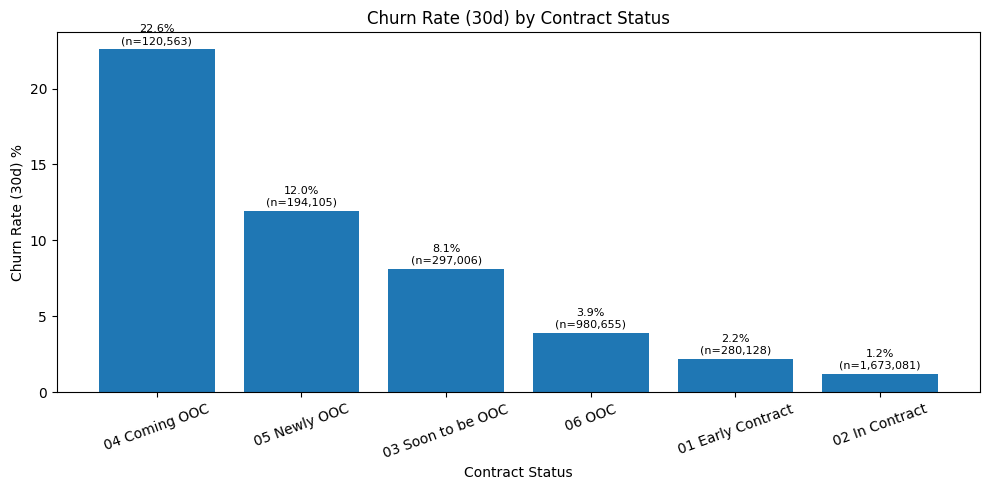

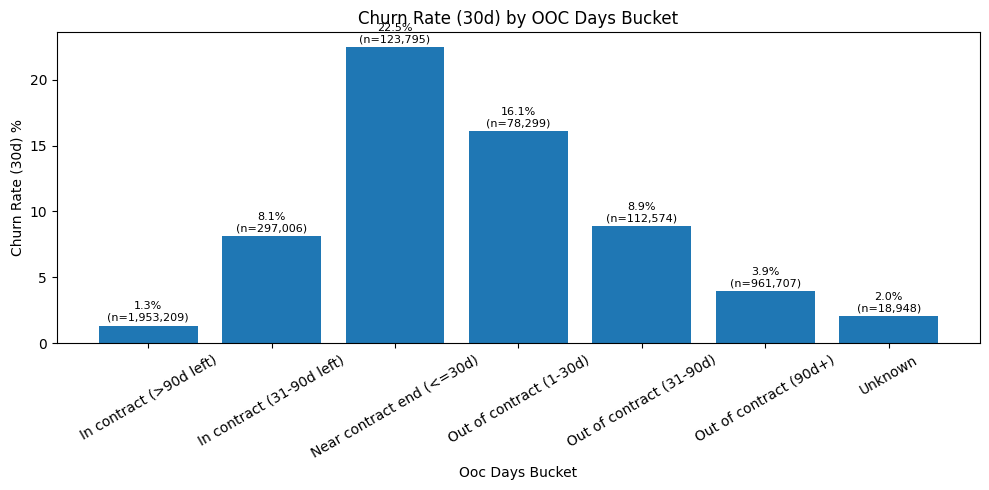

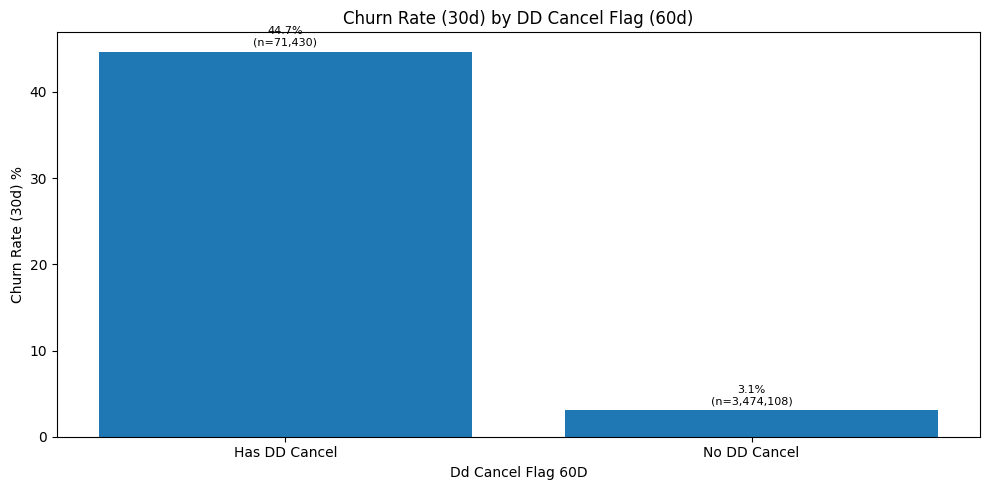

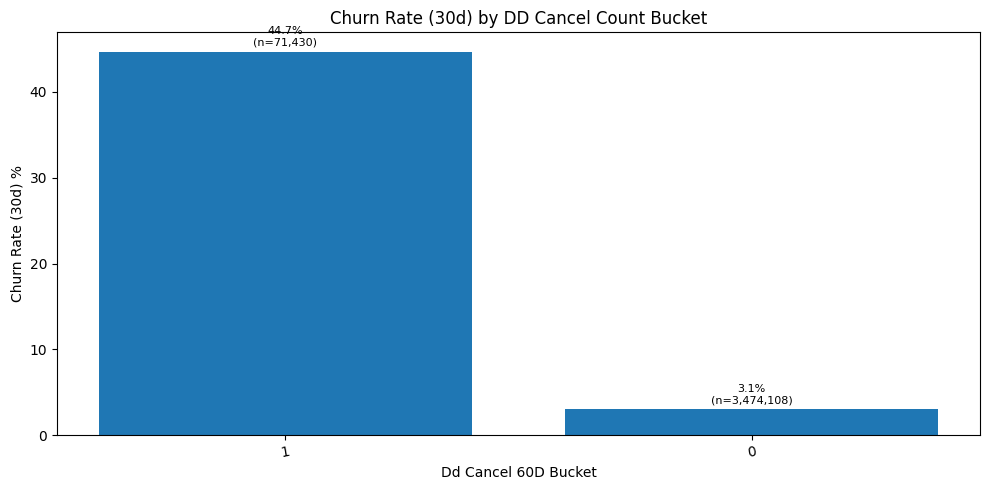

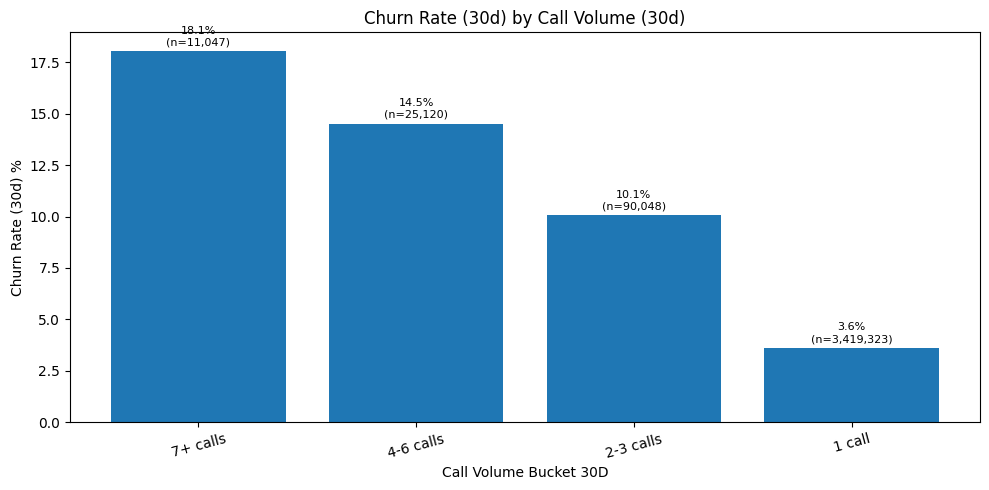

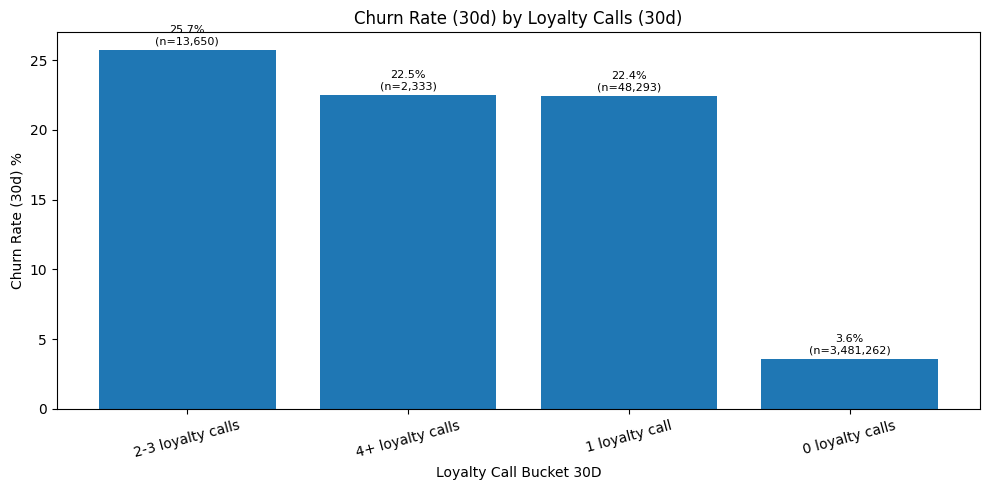

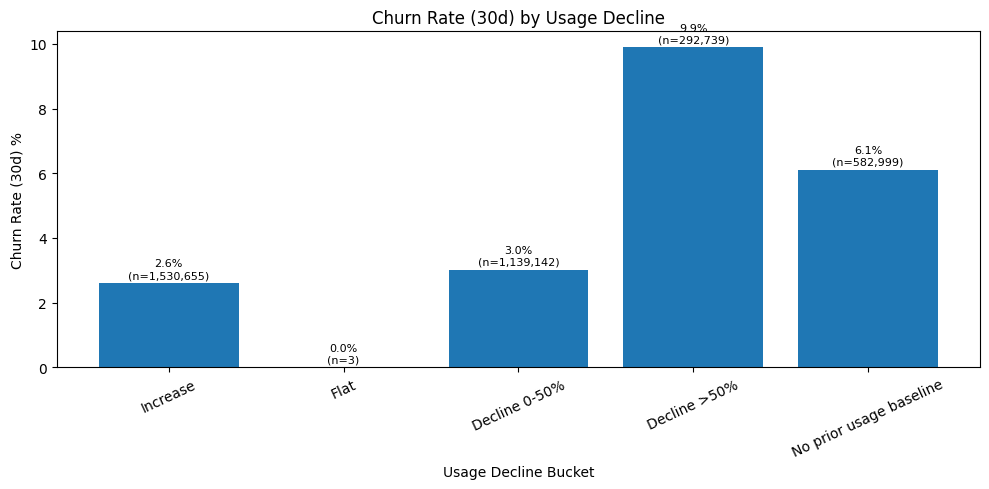

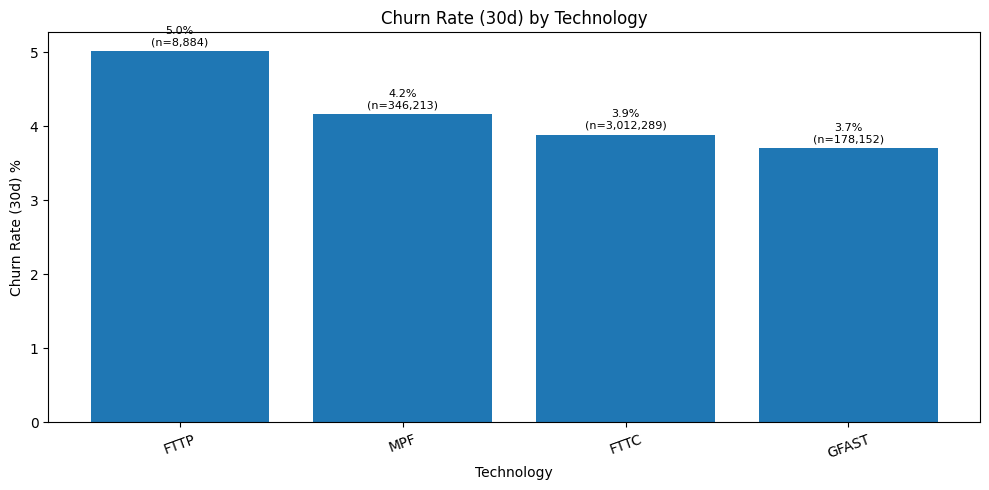

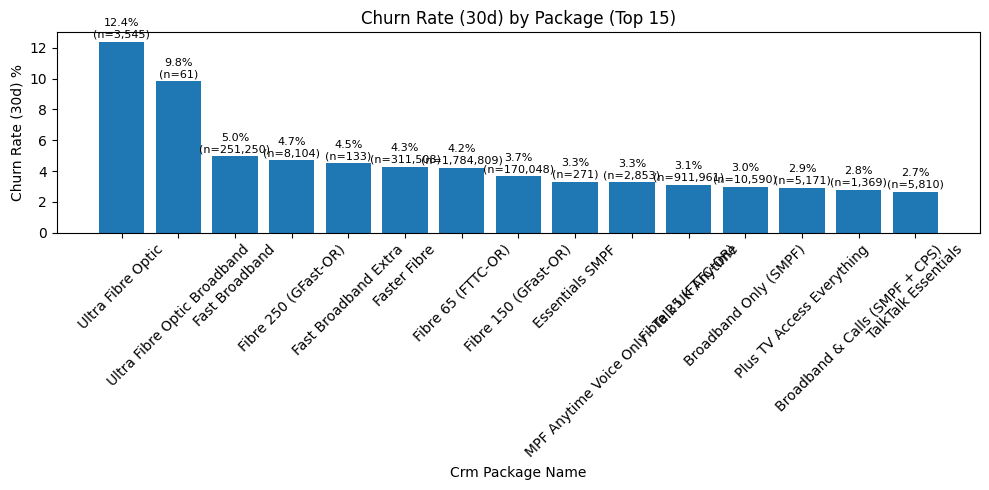

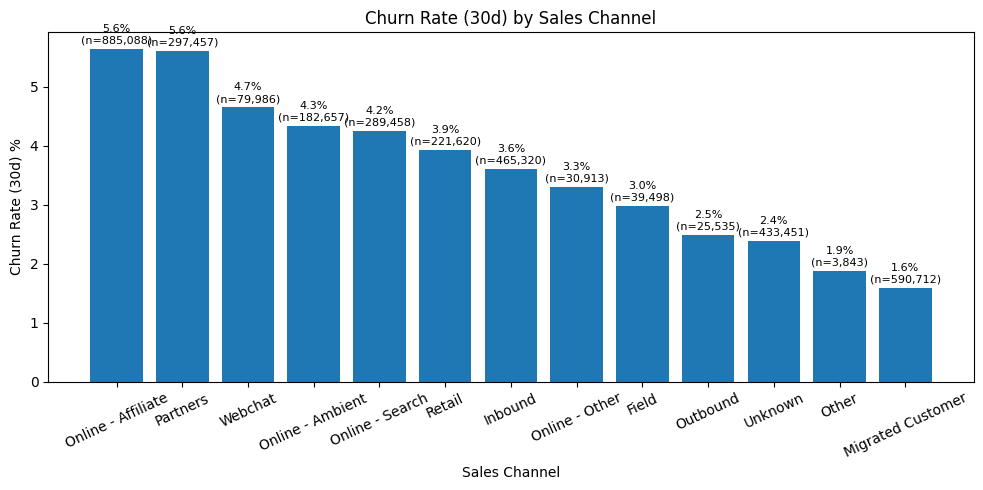

All charts saved to: C:\Users\Admin\OneDrive - University of West London\Desktop\AA\TECH_REYAL_project\Talk_talk\Churn_retention_taltalk\Notebooks\eda_outputs\charts


In [15]:
# 1) Churn by contract status
plot_churn_bar(
    df_churn_contract_status,
    category_col="contract_status",
    title="Churn Rate (30d) by Contract Status",
    filename="01_churn_by_contract_status.png",
    rotate_xticks=20
)

# 2) Churn by ooc_days bucket (custom order for storytelling)
ooc_order = [
    "In contract (>90d left)",
    "In contract (31-90d left)",
    "Near contract end (<=30d)",
    "Out of contract (1-30d)",
    "Out of contract (31-90d)",
    "Out of contract (90d+)",
    "Unknown"
]
tmp_ooc = df_churn_ooc.copy()
tmp_ooc["ooc_days_bucket"] = pd.Categorical(tmp_ooc["ooc_days_bucket"], categories=ooc_order, ordered=True)
tmp_ooc = tmp_ooc.sort_values("ooc_days_bucket")

plot_churn_bar(
    tmp_ooc,
    category_col="ooc_days_bucket",
    title="Churn Rate (30d) by OOC Days Bucket",
    filename="02_churn_by_ooc_bucket.png",
    rotate_xticks=30
)

# 3a) Churn by DD cancel flag
tmp_dd_flag = df_churn_dd_flag.copy()
tmp_dd_flag["dd_cancel_flag_60d"] = tmp_dd_flag["dd_cancel_flag_60d"].map({0: "No DD Cancel", 1: "Has DD Cancel"}).fillna(tmp_dd_flag["dd_cancel_flag_60d"].astype(str))

plot_churn_bar(
    tmp_dd_flag,
    category_col="dd_cancel_flag_60d",
    title="Churn Rate (30d) by DD Cancel Flag (60d)",
    filename="03a_churn_by_dd_flag.png",
    rotate_xticks=0
)

# 3b) Churn by DD cancel count bucket
plot_churn_bar(
    df_churn_dd_bucket,
    category_col="dd_cancel_60d_bucket",
    title="Churn Rate (30d) by DD Cancel Count Bucket",
    filename="03b_churn_by_dd_bucket.png",
    rotate_xticks=10
)

# 4a) Churn by call volume
plot_churn_bar(
    df_churn_calls,
    category_col="call_volume_bucket_30d",
    title="Churn Rate (30d) by Call Volume (30d)",
    filename="04a_churn_by_call_volume.png",
    rotate_xticks=15
)

# 4b) Churn by loyalty calls
plot_churn_bar(
    df_churn_loyalty_calls,
    category_col="loyalty_call_bucket_30d",
    title="Churn Rate (30d) by Loyalty Calls (30d)",
    filename="04b_churn_by_loyalty_calls.png",
    rotate_xticks=15
)

# 5) Churn by usage decline (custom order)
usage_order = [
    "Increase",
    "Flat",
    "Decline 0-50%",
    "Decline >50%",
    "No prior usage baseline",
    "Unknown"
]
tmp_usage = df_churn_usage_decline.copy()
tmp_usage["usage_decline_bucket"] = pd.Categorical(tmp_usage["usage_decline_bucket"], categories=usage_order, ordered=True)
tmp_usage = tmp_usage.sort_values("usage_decline_bucket")

plot_churn_bar(
    tmp_usage,
    category_col="usage_decline_bucket",
    title="Churn Rate (30d) by Usage Decline",
    filename="05_churn_by_usage_decline.png",
    rotate_xticks=25
)

# 6a) Churn by technology
plot_churn_bar(
    df_churn_tech,
    category_col="technology",
    title="Churn Rate (30d) by Technology",
    filename="06a_churn_by_technology.png",
    rotate_xticks=20
)

# 6b) Churn by package (top 15 only for readability)
plot_churn_bar(
    df_churn_package,
    category_col="crm_package_name",
    title="Churn Rate (30d) by Package (Top 15)",
    filename="06b_churn_by_package_top15.png",
    top_n=15,
    rotate_xticks=45
)

# 6c) Churn by sales channel
plot_churn_bar(
    df_churn_sales_channel,
    category_col="sales_channel",
    title="Churn Rate (30d) by Sales Channel",
    filename="06c_churn_by_sales_channel.png",
    rotate_xticks=25
)

print(f"All charts saved to: {chart_dir.resolve()}")